In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('hepatitis_csv.csv')

In [3]:
df.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live


In [4]:
df.shape

(155, 20)

In [5]:
df.isnull().sum()

age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascites             5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
histology           0
class               0
dtype: int64

In [6]:
df.describe()

,age,bilirubin,alk_phosphate,sgot,albumin,protime
count,155.000000,149.000000,126.000000,151.00000,139.000000,88.000000
mean,41.200000,1.427517,105.325397,85.89404,3.817266,61.852273
std,12.565878,1.212149,51.508109,89.65089,0.651523,22.875244
min,7.000000,0.300000,26.000000,14.00000,2.100000,0.000000
25%,32.000000,0.700000,74.250000,31.50000,3.400000,46.000000
50%,39.000000,1.000000,85.000000,58.00000,4.000000,61.000000
75%,50.000000,1.500000,132.250000,100.50000,4.200000,76.250000
max,78.000000,8.000000,295.000000,648.00000,6.400000,100.000000


In [7]:
# Preprocessing

In [9]:
def preprocess_inputs(data, drop_protime=False):
    data = data.copy()
    
    # Identify the continuous numeric features
    continuous_features = ['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime']
    
    # Fill missing values
    for column in continuous_features:
        data[column] = data[column].fillna(data[column].mean())
    
    for column in data.columns.drop(continuous_features):
        data[column] = data[column].fillna(data[column].mode().sample(1, random_state=1).values[0])
    
    # Convert the booleans columns into integer columns
        for column in data.select_dtypes('bool'):
            data[column] = data[column].astype(np.int)
    
    # Encode the sex column as a binary feature
    data['sex'] = data['sex'].replace({
        'female': 0,
        'male': 1
    })
    
    # Shuffle the data
    data = data.sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    # Change label name
    data = data.rename(columns={'class': 'label'})
    
    # Drop protime
    if drop_protime == True:
        data = data.drop('protime', axis=1)
    
    # Split df into X and y
    y = data['label']
    x = data.drop('label', axis=1)
    
    return x, y

In [10]:
x, y = preprocess_inputs(df, drop_protime=True)

C:\Users\91998\AppData\Local\Temp\ipykernel_2660\1486082101.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data[column] = data[column].astype(np.int)
C:\Users\91998\AppData\Local\Temp\ipykernel_2660\1486082101.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the relea

In [11]:
x

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,histology
0,50,0,1,0,0,0,0,1,0,0,0,0,0,1.0,139.000000,81.0,3.900000,1
1,32,0,0,1,1,1,0,1,0,0,0,0,0,1.0,55.000000,45.0,4.100000,0
2,39,0,1,0,0,0,0,1,0,0,0,0,0,1.0,85.000000,20.0,4.000000,0
3,62,0,0,0,1,1,0,1,0,0,0,0,0,1.0,105.325397,60.0,3.817266,0
4,37,0,1,0,1,0,0,1,0,0,1,0,0,0.6,67.000000,28.0,4.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,72,0,1,1,1,0,0,1,1,0,0,0,0,1.0,115.000000,52.0,3.400000,1
151,38,0,1,0,0,0,0,1,1,0,1,0,1,1.6,130.000000,140.0,3.500000,1
152,51,0,1,0,1,1,1,1,0,0,0,0,0,0.9,76.000000,271.0,4.400000,0
153,36,0,0,0,1,1,1,0,1,0,1,0,1,1.7,295.000000,60.0,2.700000,1


In [12]:
y

0      live
1      live
2      live
3       die
4       die
       ... 
150    live
151    live
152    live
153    live
154    live
Name: label, Length: 155, dtype: object

In [13]:
# Clustring

In [14]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

cluster_labels = kmeans.labels_
cluster_labels

C:\Users\91998\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0])

In [15]:
pca = PCA(n_components=2)

X_reduced = pd.DataFrame(pca.fit_transform(x), index=x.index, columns=["PC1", "PC2"])
X_reduced = pd.concat([X_reduced, y, pd.Series(cluster_labels, name='cluster')], axis=1)

centroids = pca.transform(kmeans.cluster_centers_)

C:\Users\91998\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [16]:
X_reduced

,PC1,PC2,label,cluster
0,-0.156784,33.985844,live,0
1,-47.480043,-44.246585,live,0
2,-68.074458,-11.148539,live,0
3,-25.410838,3.443089,die,0
4,-62.627490,-30.060720,die,0
...,...,...,...,...
150,-31.900658,14.081721,live,0
151,56.925060,17.084838,live,0
152,179.475538,-54.335850,live,1
153,0.161601,191.461845,live,0


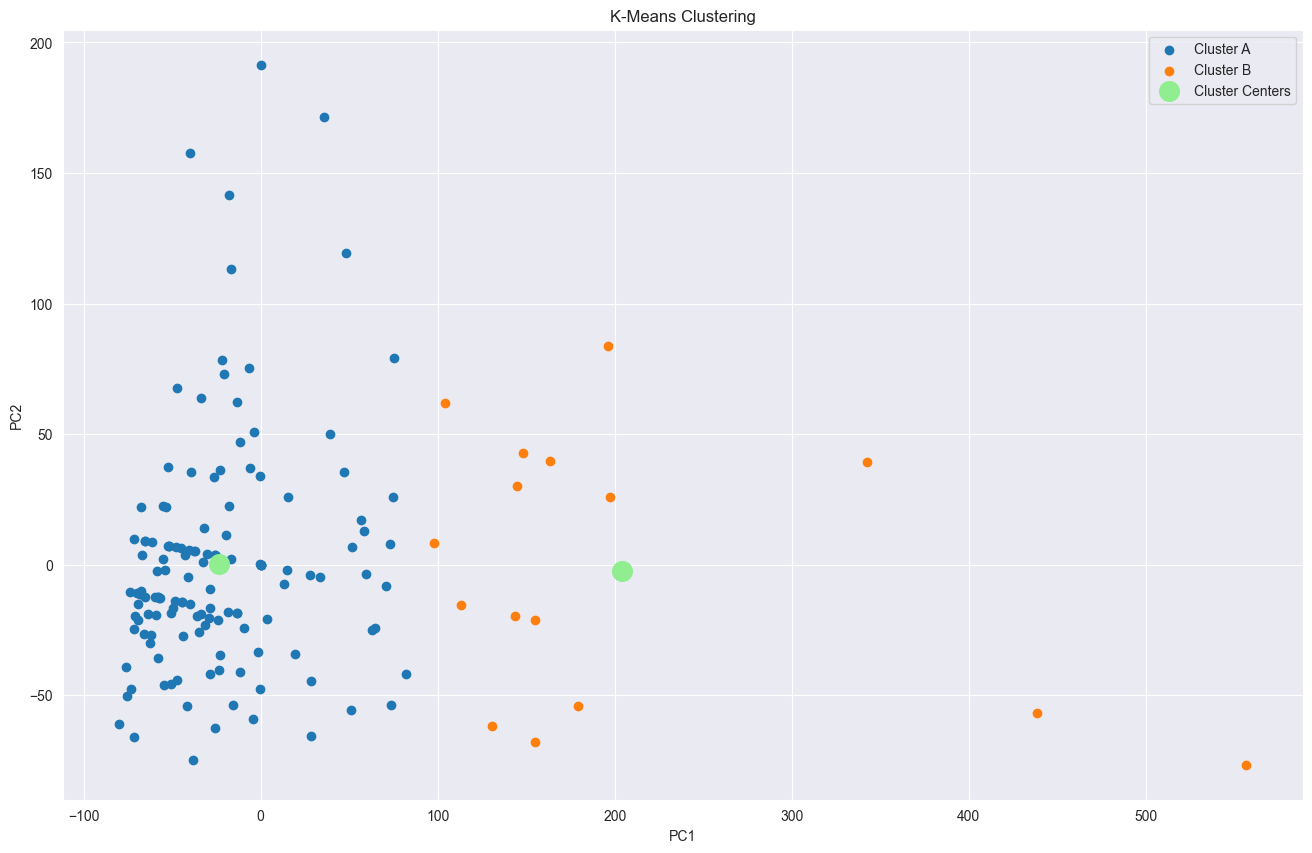

In [17]:
cluster_0_examples = X_reduced.query("cluster == 0")
cluster_1_examples = X_reduced.query("cluster == 1")

plt.figure(figsize=(16, 10))
plt.scatter(cluster_0_examples['PC1'], cluster_0_examples['PC2'], label="Cluster A")
plt.scatter(cluster_1_examples['PC1'], cluster_1_examples['PC2'], label="Cluster B")
plt.scatter(centroids[:, 0], centroids[:, 1], c='lightgreen', s=200, label="Cluster Centers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering")
plt.legend()
plt.show()

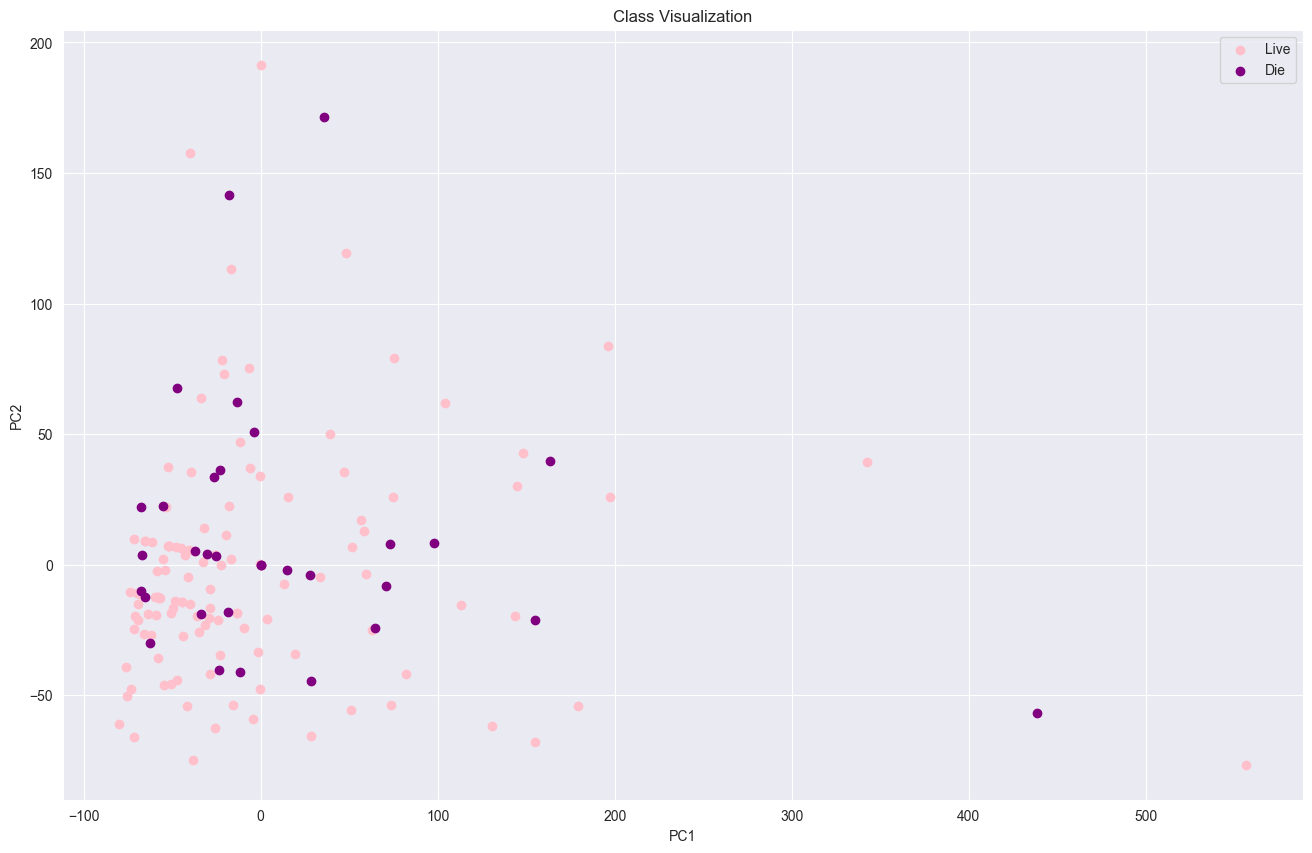

In [18]:
live_examples = X_reduced.query("label == 'live'")
die_examples = X_reduced.query("label == 'die'")


plt.figure(figsize=(16, 10))
plt.scatter(live_examples['PC1'], live_examples['PC2'], c='pink', label="Live")
plt.scatter(die_examples['PC1'], die_examples['PC2'], c='purple', label="Die")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Class Visualization")
plt.legend()
plt.show()

In [19]:
# Training

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True, random_state=1)

# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [25]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Test Accuracy: {:.2f}%".format(model.score(X_test, y_test) * 100))

Test Accuracy: 89.36%
